<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/Binario_FL_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3

In [1]:
!pip install fastai==2.6.3 -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 8.2 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

In [2]:
!pip install wwf -q

In [3]:
import timm

from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-19 16:05:35 URL:https://uc09ab79e4ef04eb34137282cf5a.dl.dropboxusercontent.com/cd/0/inline2/BnixWcJZ4Ch4QFrAQpP_ZSscjvpq5UjpUHwJNKeD9eKb15SnrvfqOaCiAWBhv6IxjzEdAfLbeSoiwHOC5ljk02LOHHQmJC2EikC0vUMOzCtoVULEexu1s7he8QlMQM58Pc30Cnae6WZEcX6buVJGzpiR4YbZXlmcEazVMm0siwIoDIkM_q1gPyMrZcBmFxQ_y6IMtI1yl8duwuMHXhXAiyricNtvoAVpoomPkk9EMaEbFxJW7IXpNJ4yAThrkxZal28s84Lclzu3nWqXskH3MBSF6XCX4aXmxyK_buD_oVpdJLKKpZYAnCeg85DkmDBgA_LTm_wYH1Q0SNRWazGzfX9FJPDwp2J3ZUiAsNS7cypTf7IbTRDVKwTrN4tj8S9H56rfDsTWo9uK6wDvukJaiphlFN_BtuAqidO6vGAV4JRaPA/file [138777773/138777773] -> "train.zip" [1]
2022-06-19 16:05:37 URL:https://ucc8d1010318a9eebc26f32b4423.dl.dropboxusercontent.com/cd/0/inline2/BniDiqJv6-Uxh8mbQNYZRVpuOWdWrRM6RlbuxksXFpKZkdsu7_5FhLs9k3RlTzX69jRRZpVMPUPDirdb61gWca0nAUsXuVI855xod8sPJmwGincPE4mSmxtRC9bVvFJT8VCkHLdaEaVK5d5-KsnDlySO29U03XWLemkwhkWQCEc2BvrP-gVn5p4uKHiZ9sSTghAa55nTBjIYh23Llsuw6u3EHpR12axfh8nb_siU-wivhwS-ZdKDyjGr8ZMjSrXXiVwnJ17R__QthYgUtda7NarzKNBlEC7l3z21GaoGnuJl0dn-30MQXyjZR8Wf0uN2Jwu

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [10]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [11]:
path = Path('dataset')

In [12]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [13]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [14]:
dls = db.dataloaders(path,bs=128)

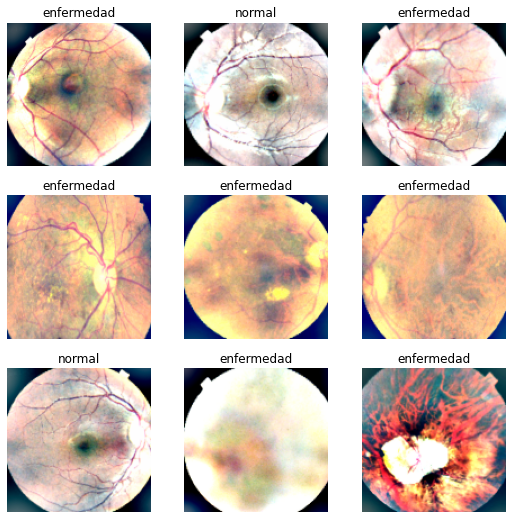

In [15]:
dls.show_batch()

In [16]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [39]:
metrics=[ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = timm_learner(dls, 'inception_v3', loss_func=FocalLoss(), metrics=metrics, cbs=callbacks)

SuggestedLRs(minimum=0.005754399299621582, steep=9.12010818865383e-07, valley=0.0004786300996784121, slide=0.00363078061491251)

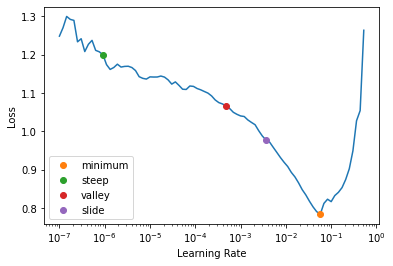

In [40]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.122294,0.643467,0.410937,0.147826,0.380597,0.212944,0.589063,00:13


Better model found at epoch 0 with valid_loss value: 0.6434668302536011.


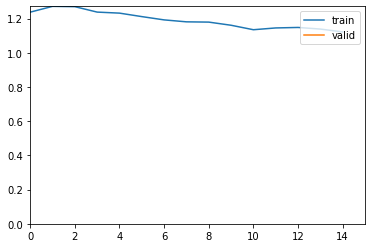

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,0.995795,0.584659,0.500000,0.177083,0.380597,0.241706,0.500000,00:15
1,1.018014,0.592260,0.482812,0.177049,0.402985,0.246014,0.517187,00:10
2,1.020941,0.522626,0.529688,0.191882,0.388060,0.256790,0.470313,00:12
3,1.017720,0.510519,0.490625,0.171233,0.373134,0.234742,0.509375,00:11
4,1.009857,0.464796,0.528125,0.195652,0.402985,0.263415,0.471875,00:10
5,0.999029,0.456316,0.510938,0.202658,0.455224,0.280460,0.489062,00:10
6,1.006667,0.480032,0.479688,0.177994,0.410448,0.248307,0.520312,00:10
7,0.985150,0.478136,0.479688,0.171617,0.388060,0.237986,0.520312,00:11
8,0.974991,0.485685,0.470313,0.182663,0.440299,0.258206,0.529688,00:10
9,0.952289,0.475823,0.489062,0.181518,0.410448,0.251716,0.510938,00:11


Better model found at epoch 0 with valid_loss value: 0.5846585035324097.


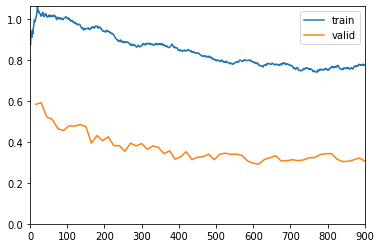

Better model found at epoch 2 with valid_loss value: 0.5226262211799622.
Better model found at epoch 3 with valid_loss value: 0.5105192065238953.
Better model found at epoch 4 with valid_loss value: 0.4647957682609558.
Better model found at epoch 5 with valid_loss value: 0.4563163220882416.
Better model found at epoch 10 with valid_loss value: 0.39518240094184875.
Better model found at epoch 14 with valid_loss value: 0.38247865438461304.
Better model found at epoch 15 with valid_loss value: 0.3823188841342926.
Better model found at epoch 16 with valid_loss value: 0.35462552309036255.
Better model found at epoch 23 with valid_loss value: 0.34305331110954285.
Better model found at epoch 25 with valid_loss value: 0.3159472346305847.
Better model found at epoch 28 with valid_loss value: 0.3140619099140167.
Better model found at epoch 32 with valid_loss value: 0.3137843906879425.
Better model found at epoch 38 with valid_loss value: 0.3069896697998047.
Better model found at epoch 39 with va

In [41]:
%%time
learn.fine_tune(60,base_lr=1e-5)

## Evaluando el Modelo

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [43]:
learn.dls = dlsTest

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5249999761581421.


(#6) [0.8609205484390259,0.5249999761581421,0.22402597402597402,0.5149253731343284,0.31221719457013575,0.4749999940395355]

Exportamos el modelo:

In [45]:
learn.to_fp32()
learn.export('Binario_FL_inception_v3.pkl')

## Interpretación del modelo

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


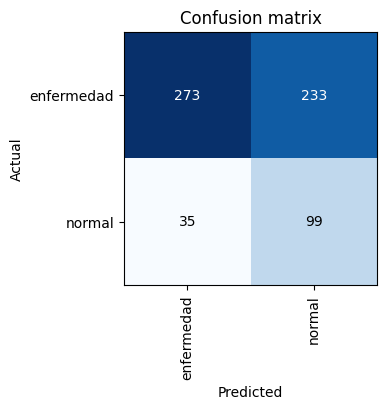

In [46]:
learn_inf = load_learner('Binario_FL_inception_v3.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)